In [13]:
%matplotlib inline
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

In [14]:
df = pd.read_csv('AirPassengers.csv')
df.columns = ['Date','Number of Passengers']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.head())

            Number of Passengers
Date                            
1949-01-01                   112
1949-02-01                   118
1949-03-01                   132
1949-04-01                   129
1949-05-01                   121


Split dataset to train dataset and test dataset.
test dataset is the last 4 months, such as 1960, December, Novermber, October, September.

In [18]:
test_dates = df.index[-4:]
train_dates = df.index[:-4]
train_data = df.loc[train_dates]
test_data = df.loc[test_dates]
print(train_data.tail())
print(test_data.head())

            Number of Passengers
Date                            
1960-04-01                   461
1960-05-01                   472
1960-06-01                   535
1960-07-01                   622
1960-08-01                   606
            Number of Passengers
Date                            
1960-09-01                   508
1960-10-01                   461
1960-11-01                   390
1960-12-01                   432


Use ADF to judge if train dataset is stationary.

In [19]:
print("ADF (Augmented Dickey-Fuller Test)")
result = adfuller(train_data['Number of Passengers'])
print(f"p-value: {result[1]:.6f}")
if result[1] <= 0.05:
    print("Reject the null hypothesis. The series is stationary.")
else:
    print("Fail to reject the null hypothesis. The series is non-stationary.")

ADF (Augmented Dickey-Fuller Test)
p-value: 0.994631
Fail to reject the null hypothesis. The series is non-stationary.


We found train dataset is no-stationary. So we need to do transform.

We use difference to de-tread.

In [20]:
train_data['Difference'] = train_data['Number of Passengers'].diff()
print(train_data.head())
result = adfuller(train_data['Difference'].dropna())
print(f"p-value: {result[1]:.6f}") 

            Number of Passengers  Difference
Date                                        
1949-01-01                   112         NaN
1949-02-01                   118         6.0
1949-03-01                   132        14.0
1949-04-01                   129        -3.0
1949-05-01                   121        -8.0
p-value: 0.042753


Because the seasonal, we found it is 12 months. So we use defference 12 months to remove seasonality.

In [21]:
train_data['Seasonal Difference'] = train_data['Difference'] - train_data['Difference'].shift(12)
print(train_data.head())

            Number of Passengers  Difference  Seasonal Difference
Date                                                             
1949-01-01                   112         NaN                  NaN
1949-02-01                   118         6.0                  NaN
1949-03-01                   132        14.0                  NaN
1949-04-01                   129        -3.0                  NaN
1949-05-01                   121        -8.0                  NaN


In [22]:
result = adfuller(train_data['Seasonal Difference'].dropna())
print(f"p-value: {result[1]:.6f}")

p-value: 0.000000


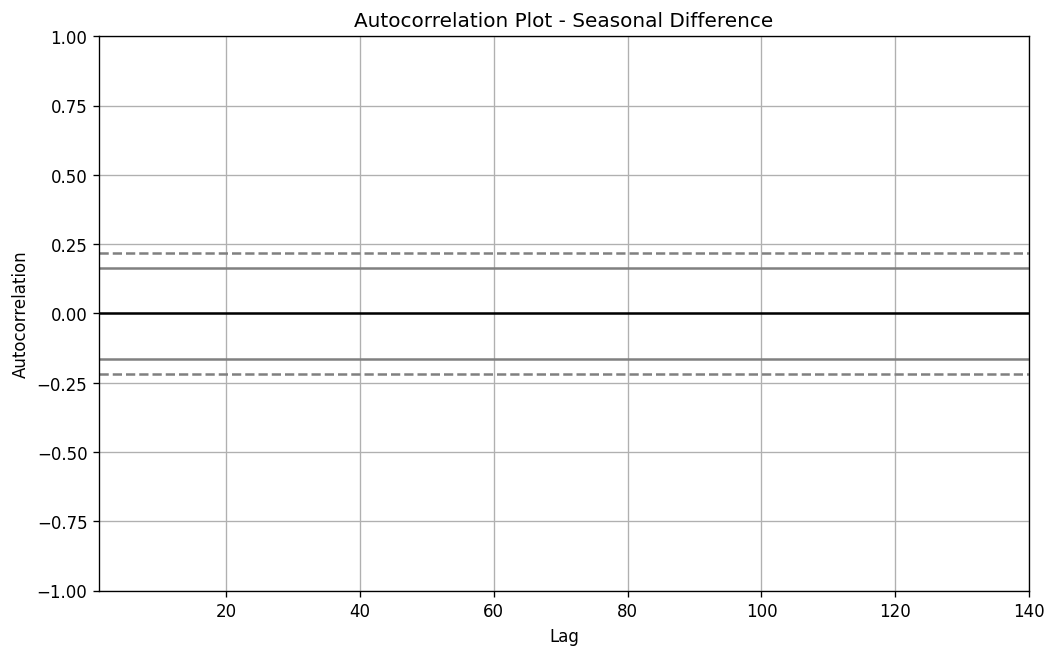

In [23]:
plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 120})
autocorrelation_plot(train_data['Seasonal Difference'].tolist())
plt.title('Autocorrelation Plot - Seasonal Difference')
plt.show()

Above the graph, The autocorrelation plot shows the dataset is stationary.
So we can use this train dataset (after de-trend and de-seasonal) to train ARMA mdoel. 
ARIMA (p, 0, q) = ARMA

In [ ]:
best_aic = np.inf
best_order = None
data = train_data['Seasonal Difference'].values
# Find the best p and q with for way.
for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = ARIMA(data, order=(p, 0, q))
            fitted_model = model.fit()
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_order = (p, q)
        except:
            continue
print(f"The best model ARMA{best_order}, AIC: {best_aic:.2f}")
print(f"p: {best_order[0]}, q: {best_order[1]}")

model = ARIMA(data, order=(best_order[0], 0, best_order[1]))
fitted_model = model.fit()
print(fitted_model.summary())

c:\Users\zsb\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\zsb\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zsb\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\zsb\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

The best model ARMA(3, 2), AIC: 982.48
p: 3, q: 2
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  140
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -484.242
Date:                Sat, 13 Dec 2025   AIC                            982.483
Time:                        21:45:04   BIC                           1003.075
Sample:                             0   HQIC                           990.851
                                - 140                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2446      0.136      1.799      0.072      -0.022       0.511
ar.L1         -0.3849      0.115     -3.351      0.001      -0.610      -0.160
ar

c:\Users\zsb\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Original data: [112, 118, 132, 129, ...] (with trend and seasonality)
After differencing: [NaN, 6, 14, -3, ...] (removing trend, smaller values)
After seasonal differencing: [NaN, ..., 5, 1, -3, ...] (removing seasonality, smaller values)

This [NaN, ..., 5, 1, -3, ...] format cannot be compared with the original data (test dataset). Therefore, we use an inverse transformation to convert these differencing data back into a comparable original data format, such as [521, 457, 416, 455], and then compare it with the test dataset's [508, 461, 390, 432] to see if they are similar.

If they are similar, the model is successful.

We've set up a separate custom function specifically for converting data formats.

In [25]:
def inverse_transform(seasonal_diff_predictions, last_diff_values, last_passenger_value):
    diff_predictions = []
    passenger_predictions = []
    for i in range(len(seasonal_diff_predictions)):
        if i < 12:
            hist_idx = -(12 - i)
            diff_pred = seasonal_diff_predictions[i] + last_diff_values[hist_idx]
        else:
            diff_pred = seasonal_diff_predictions[i] + diff_predictions[i-12]
        diff_predictions.append(diff_pred)
        if i == 0:
            passenger_pred = diff_pred + last_passenger_value
        else:
            passenger_pred = diff_pred + passenger_predictions[i-1]
        passenger_predictions.append(passenger_pred)
    return passenger_predictions, diff_predictions

Beause test dataset has only four months data, so we use steps=4, let fitted modle to predict four months values.

In [27]:
seasonal_diff_predictions = fitted_model.forecast(steps=4)

last_diff_values = train_data['Difference'].tail(12).values
last_passenger_value = train_data['Number of Passengers'].iloc[-1]

passenger_predictions, diff_predictions = inverse_transform(
    seasonal_diff_predictions, 
    last_diff_values, 
    last_passenger_value
)
forecast_index = test_data.index
predictions_df = pd.DataFrame({
    'Date': forecast_index,
    'Predicted_Passengers': passenger_predictions
})
predictions_df.set_index('Date', inplace=True)

print("\n Prediciton:")
print(predictions_df)
print("\n Actual:")
print(test_data)


 Prediciton:
            Predicted_Passengers
Date                            
1960-09-01            521.396614
1960-10-01            457.713813
1960-11-01            416.479692
1960-12-01            455.769737

 Actual:
            Number of Passengers
Date                            
1960-09-01                   508
1960-10-01                   461
1960-11-01                   390
1960-12-01                   432


From above result, we can find the predict values (four months data) are similar as the test dataset (four months data). 

For clarity, we draw a plot to compare the predicted values with the actual values.

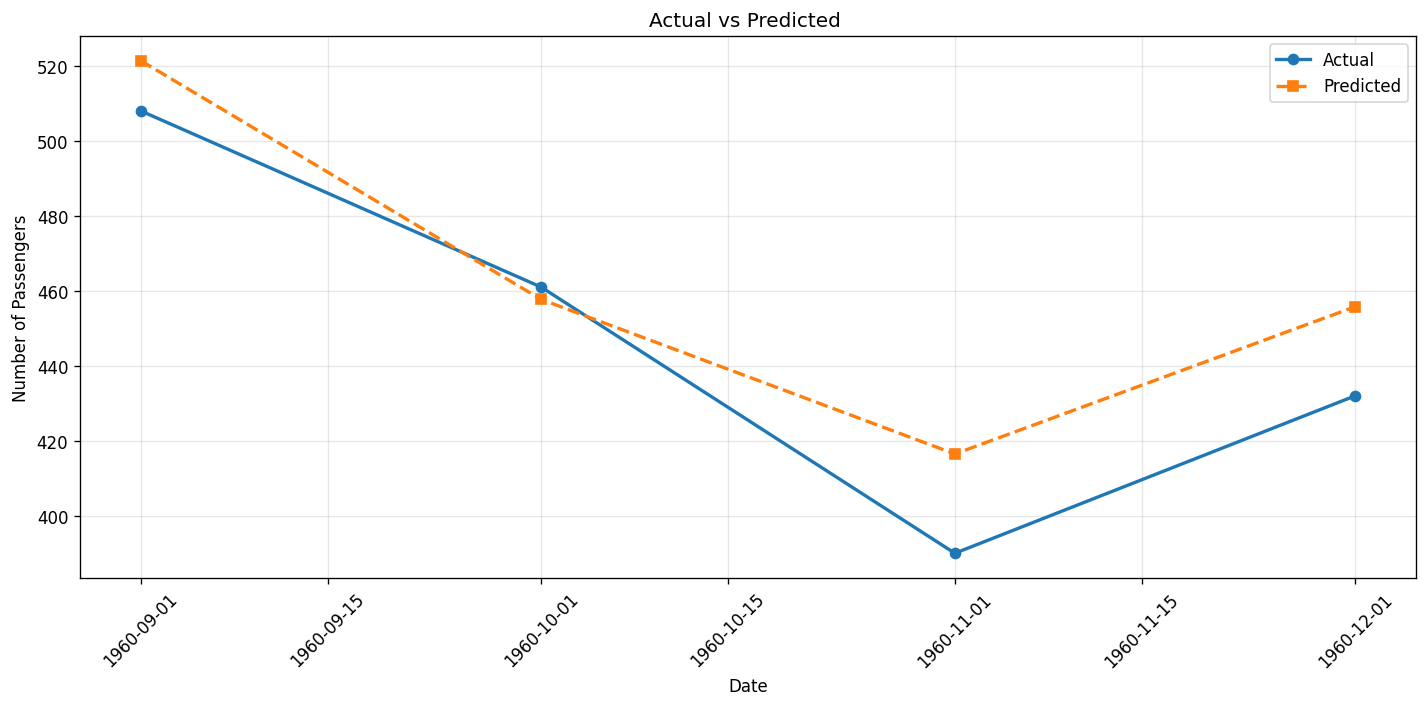


MAPE: 3.91%


In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Number of Passengers'], label='Actual', marker='o', linewidth=2)
plt.plot(forecast_index, passenger_predictions, label='Predicted', marker='s', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Actual vs Predicted ')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

mape = (abs(test_data['Number of Passengers'] - passenger_predictions) / test_data['Number of Passengers']).mean()
print(f"\nMAPE: {mape:.2%}")

A MAPE of 4% indicates that our ARMA model predicts monthly passenger numbers for September, October, November, and December 1960 with high accuracy.